# Lane Detection Pipeline 
#### Alvee Hoque 9/21/21

Lane Detection Pipeline using Hough Transform with images taken from CARLA. Project idea is to track lanes and then have car take action using the data. However, Hough transform is not the ideal solution for lane detection. It does not take into consideration curved lines and also lane markings. Here from CARLA images, we don't always have the lane marked in certain frames.

In [4]:
#imports
import numpy as np 
import cv2 as cv 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

%matplotlib inline

### Demo Run 

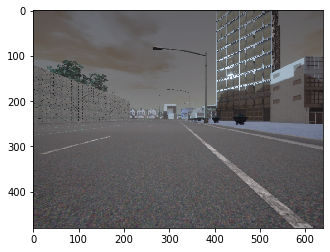

In [5]:
# read image
# image = mpimg.imread('test_images/solidWhiteRight.jpg')
image = cv.imread('Datasets/personal_run/003421.png')
plt.imshow(image)

In [6]:
#image shape
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)

In [7]:
gray = cv.cvtColor(image,cv.COLOR_RGB2GRAY)
# cv.imshow('Gray', gray)
# cv.waitKey(0)
# cv.destroyAllWindows()

kernel_size = 5
blur_gray = cv.GaussianBlur(gray, (kernel_size,kernel_size),0)

In [8]:
# cv.imshow('blur_gray',blur_gray)
# cv.waitKey(0)
# cv.destroyAllWindows()

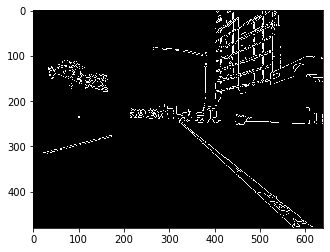

In [9]:
low_threshold = 20
high_threshold = 150
edges = cv.Canny(blur_gray,low_threshold,high_threshold)

#show image
plt.imshow(edges, cmap='gray')

In [10]:
# masked edged 
mask = np.zeros_like(edges)
ignore_mask_color = 255

imshape = image.shape
vertices = np.array([[(0,300),(220, 220), (310, 220), (imshape[1],imshape[0])]], dtype=np.int32)
cv.fillPoly(mask,vertices,ignore_mask_color)
masked_edges = cv.bitwise_and(edges,mask)

In [11]:
# Hough Transform Parameters
rho = 1 
theta = np.pi/180 
threshold = 2     
min_line_length = 4
max_line_gap = 5    

# create blank image to draw on 
line_image = np.copy(image)*0 

In [159]:
# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

In [13]:
# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

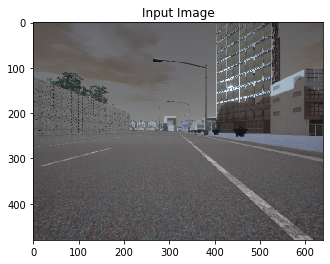

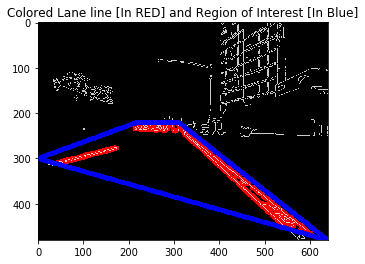

In [14]:
# Create a color binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv.addWeighted(color_edges, 0.8, line_image, 1, 0)
lines_edges = cv.polylines(lines_edges,vertices, True, (0,0,255), 10)
plt.imshow(image)
plt.title("Input Image")
plt.show()
plt.imshow(lines_edges)
plt.title("Colored Lane line [In RED] and Region of Interest [In Blue]")
plt.show()

# Pipeline 

1. Gray Scale
2. Gaussian Blur
3. Canny Edge Detection 
4. Region Masking
5. Hough Transform 
6. Draw lines

In [15]:
import math
import numpy as np 
import cv2 as cv 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

%matplotlib inline

In [206]:
# functions 

def grayscale(img):
    return cv.cvtColor(img, cv.COLOR_BGR2GRAY)


def gaussian_blur(img, kernel_size):
    return cv.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    return cv.Canny(img, low_threshold, high_threshold)


def region_mask(img, vertices):
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv.bitwise_and(img, mask)
    return masked_image
    
def draw_lines(img, lines, color=(255, 0, 0), thickness = 10):
    for line in lines: 
        for x1,y1,x2,y2 in line: 
            cv.line(img, (x1,y1), (x2,y2), color, thickness)
            
def slope(img, lines):
    image = np.copy(img)
    poly_vertices = []
    order = [0,1,3,2]
    
    left = []
    right = []
    
    for line in lines: 
        for x1,y1,x2,y2 in line: 
            
            if x1==x2:
                pass
            else: 
                m = (y2-y1) / (x2-x1) 
                c = y1 -m*x1
                
                if m < 0:
                    left.append((m,c))
                else:
                    right.append((m,c))
                    
    line_left = np.mean(left, axis=0)
    line_right = np.mean(right, axis=0)
    
    for slope, intercept in [line_left, line_right]:
        
        rows, cols = image.shape[:2]
        y1 = int(rows)
        
        y2 = int(rows*0.6)
        
        # x = (y-c)/m
        x1 = int((y1-intercept)/slope)
        x2 = int((y2-intercept)/slope)
        
        poly_vertices.append((x1,y1))
        poly_vertices.append((x2,y2))
        
        
        #call draw lines function
        draw_lines(image, np.array([[[x1,y1,x2,y2]]]))
        
    poly_vertices = [poly_vertices[i] for i in order]
    #fill region with blue color 
    cv.fillPoly(image, pts=np.array([poly_vertices], 'int32'), color =(0,255,0))
    return cv.addWeighted(img, 0.7, image, 0.4, 0.)


def hough_lines(img, rho, theta, threshold ,min_line, max_gap):
    lines = cv.HoughLinesP(img, rho, theta, threshold, np.array([]) ,min_line, max_gap)
    line_img = np.zeros((img.shape[0], img.shape[1],3), dtype=np.uint8)
    
    line_img = slope(line_img,lines)
    return line_img


def get_vertices(image):
    
    # for carla image we'll do custom vertices 
    # vertices used before do not give us good lane detection, it gives awkward shapes
    
    bottom_left  = [500,300]
    top_left     = [100,300]
    top_right    = [310,220]
    bottom_right = [600, 465] 
    
    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return ver


def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
    lines_edges = cv.addWeighted(initial_img, α, img, β, γ)
    
    #this gets the blue mask 
    #lines_edges = cv.polylines(lines_edges,get_vertices(img), True, (0,0,255), 10) 
    return lines_edges




In [255]:
def lane_pipeline(image):
    
    #grayscale
    gray_img = grayscale(image)
    #guassian 
    gaussian_img = gaussian_blur(img=gray_img, kernel_size=5)
    #canny edge 
    canny_img = canny(img=gaussian_img, low_threshold=20, high_threshold=150)
    #masked image
    masked_img = region_mask(img = canny_img, vertices=get_vertices(image))
    #hough transform 
    hough = hough_lines(img = masked_img, rho=1, theta = np.pi/180, threshold=2, min_line=4, max_gap=5)
    # draw lines 
    output = weighted_img(img=hough, initial_img=image, α=0.8, β=1., γ=0.)
    return output

In [259]:

img = lane_pipeline(image)
plt.imshow(img)

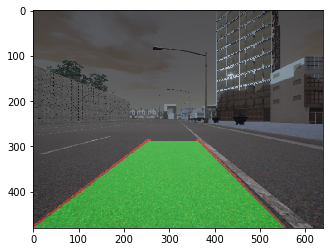

## Test Images

In [251]:
import os 

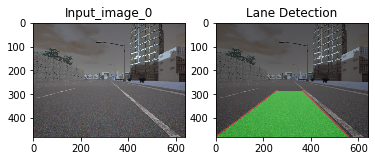

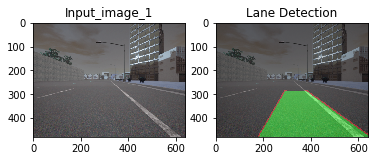

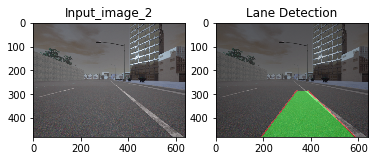

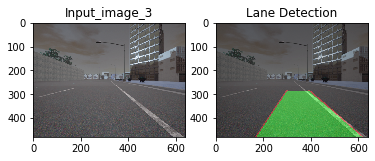

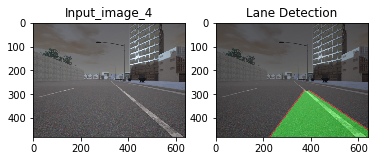

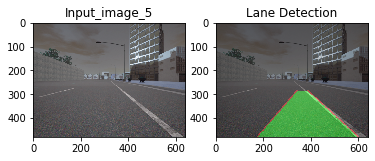

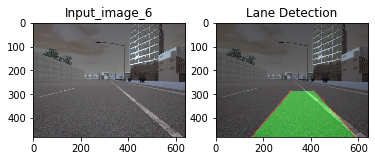

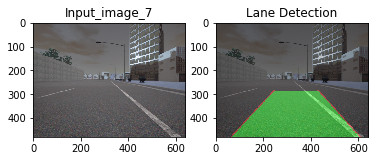

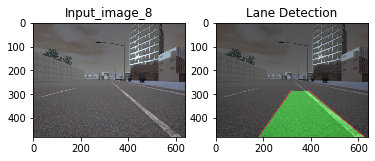

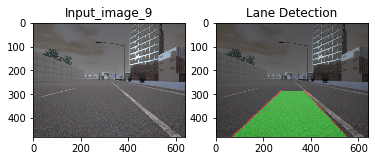

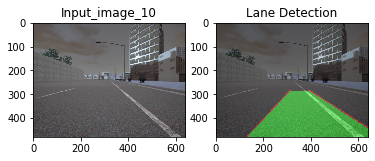

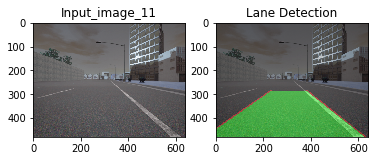

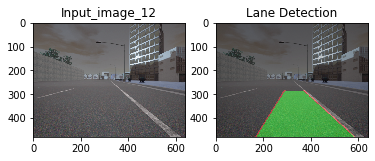

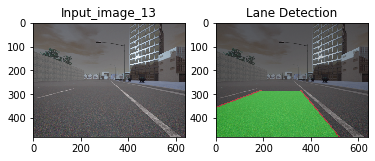

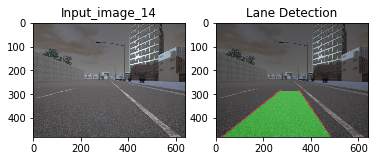

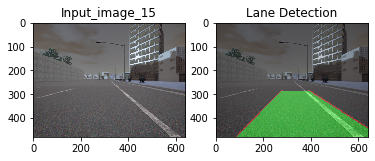

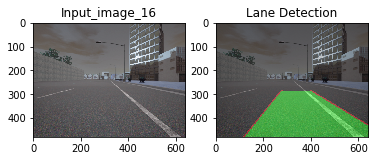

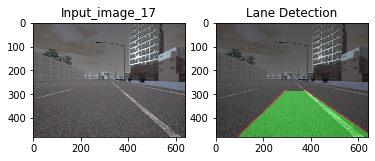

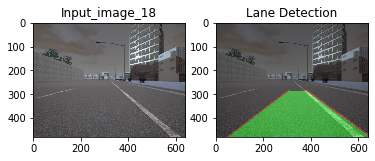

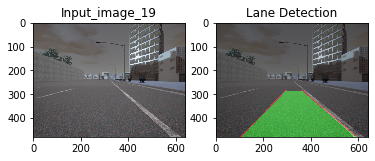

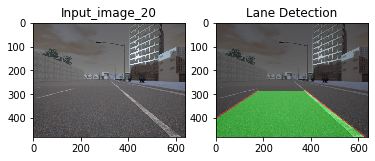

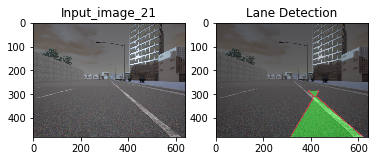

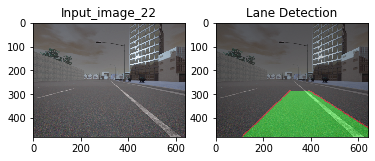

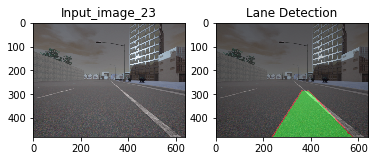

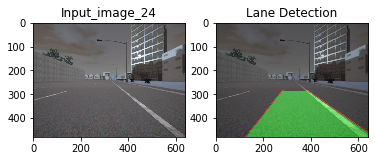

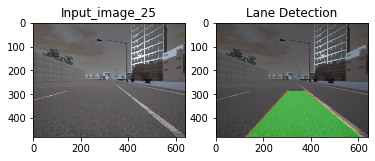

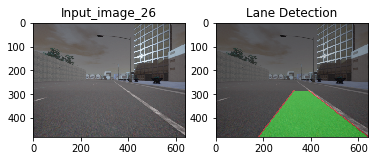

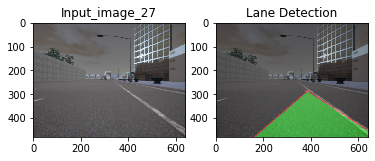

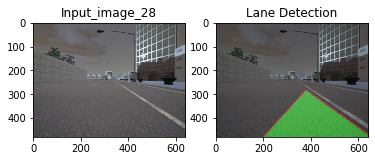

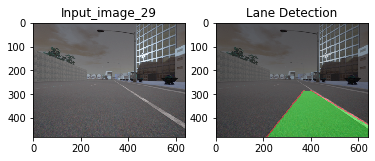

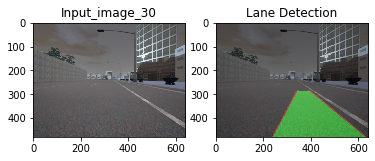

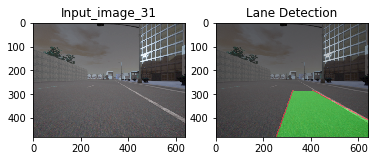

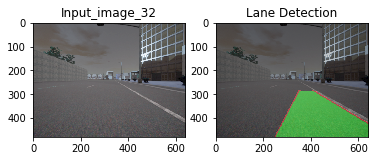

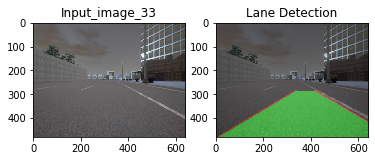

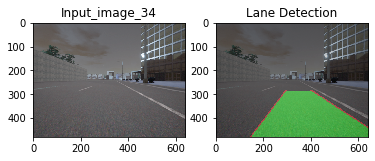

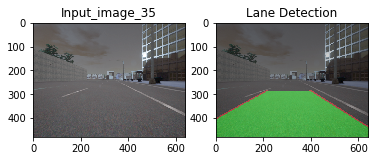

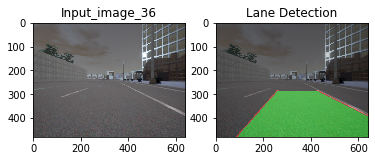

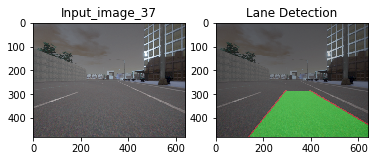

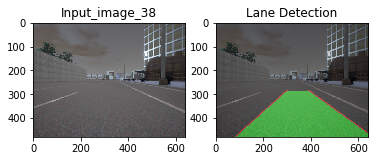

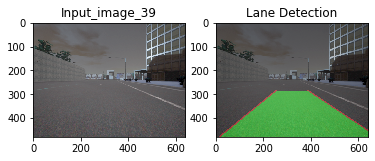

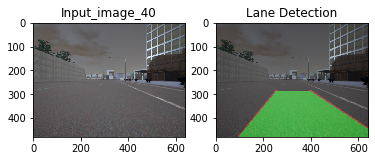

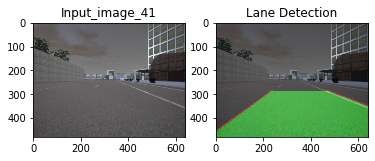

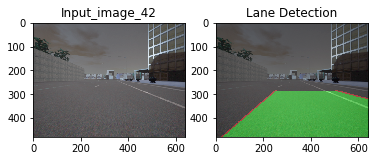

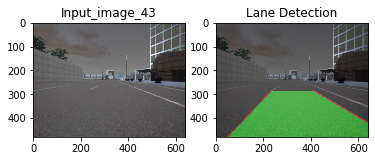

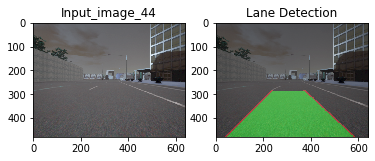

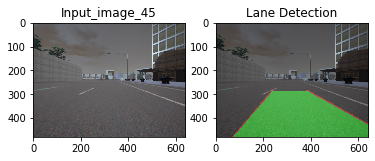

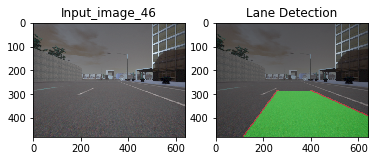

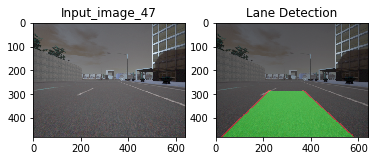

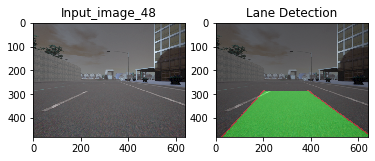

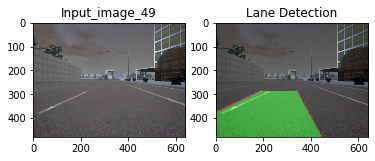

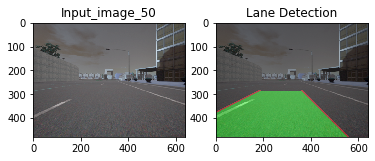

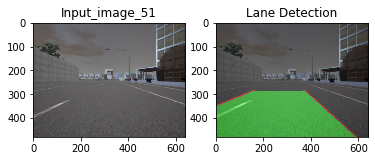

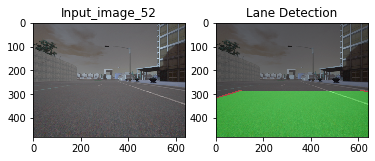

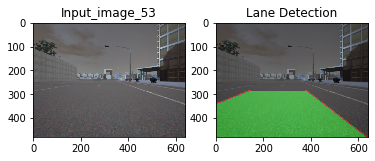

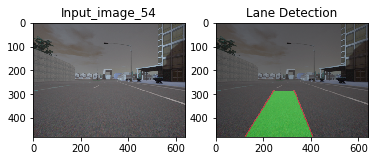

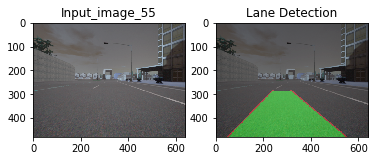

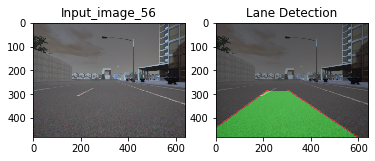

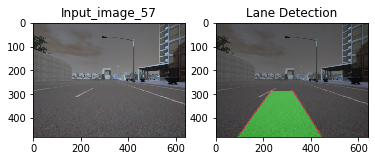

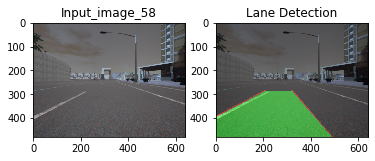

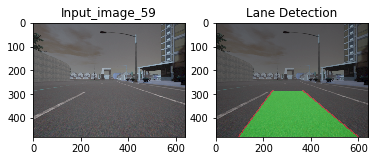

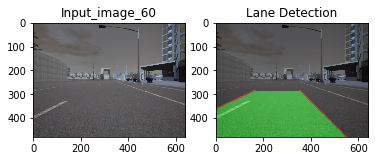

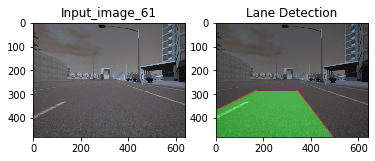

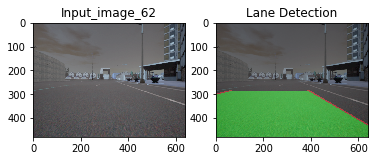

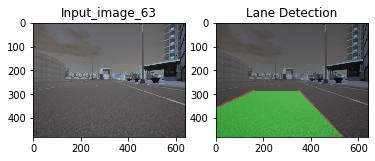

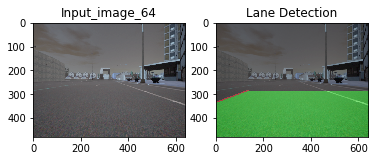

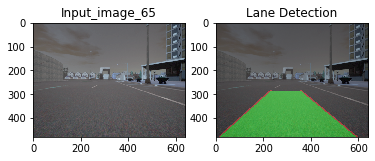

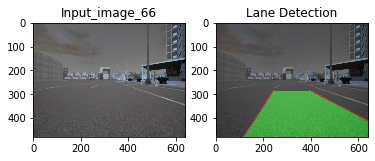

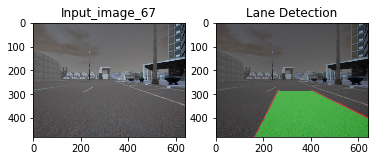

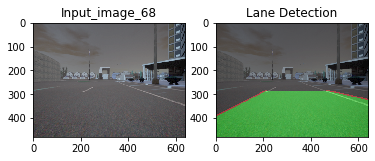

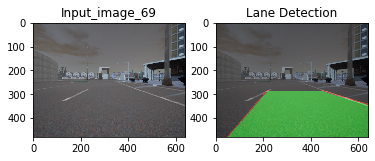

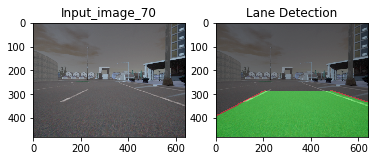

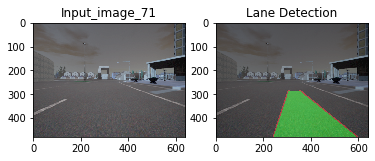

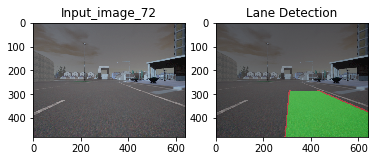

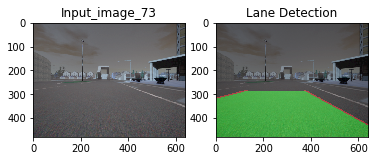

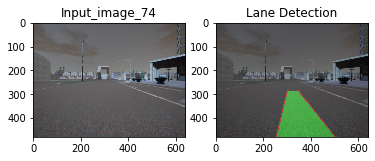

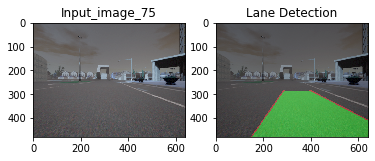

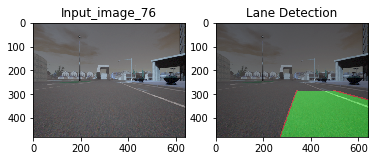

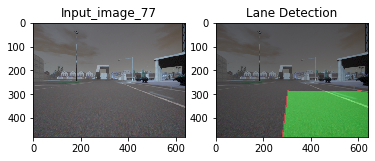

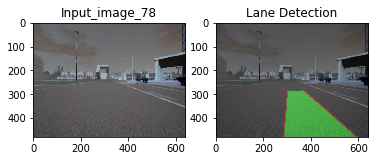

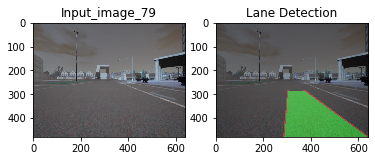

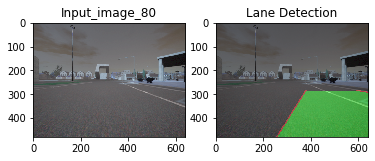

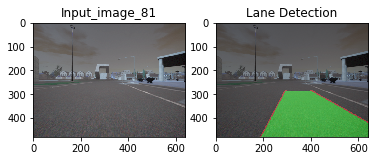

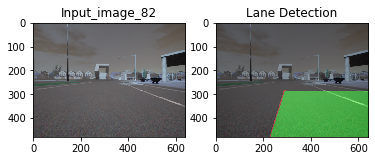

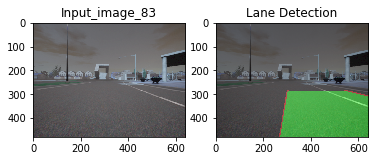

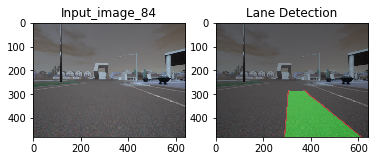

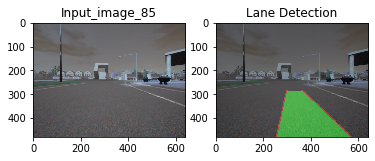

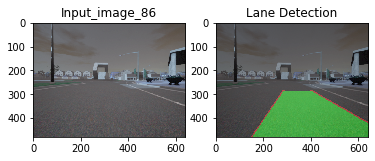

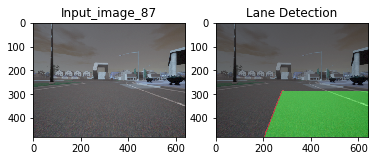

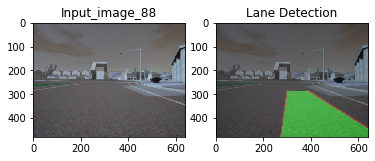

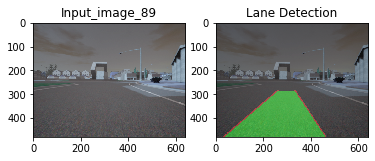

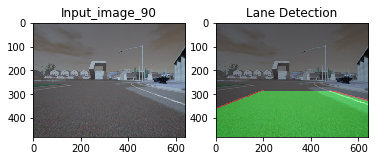

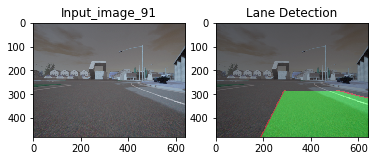

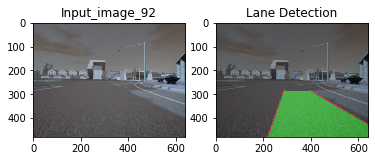

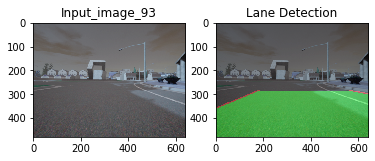

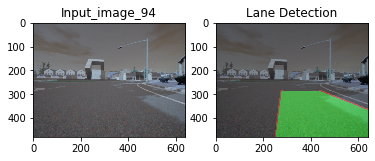

TypeError: cannot unpack non-iterable numpy.float64 object

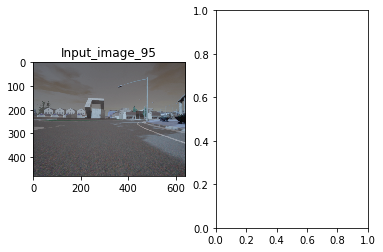

In [262]:
count = 0 
for path in list(os.listdir('./Datasets/personal_run/')):
    
    fig = plt.figure()
    image = cv.imread(f'./Datasets/personal_run/{path}')
    ax = fig.add_subplot(1,2,1)
    plt.imshow(image)
    ax.set_title(f"Input_image_{count}")
    ax = fig.add_subplot(1,2,2)
    img = lane_pipeline(image)
    plt.imshow(lane_pipeline(image))
    ax.set_title("Lane Detection")
    plt.show()
    
    #checking first 100 files
    count += 1     
    if count == 100: 
        break
    

### Notes
1. Does not work on curves. We get an error on image 95 where there are no lines detected
2. Will explore different methods on lane detection
3. Will test on live video 